## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
為 0.3 * focal loss + 0.7 cross-entropy
"""

def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

def combined_loss(ce_weight, gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    """Define the customized loss."""
    def combined_loss_keras(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl*(1-ce_weight)+ce*ce_weight, axis=1)
        return tf.reduce_mean(reduced_fl)
    return combined_loss_keras

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}


W0726 08:02:18.518672  8136 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:71: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 08:02:18.562582  8136 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:514: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 08:02:18.575547  8136 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4076: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 08:02:18.662381  8136 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:130: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, ce_weight: 0.00


W0726 08:02:18.890799  8136 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0726 08:02:18.998482  8136 deprecation.py:323] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0726 08:02:19.272776  8136 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:983: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 117us/step - loss: 6.0796 - acc: 0.3294 - val_loss: 6.1177 - val_acc: 0.3433
Epoch 2/25
50000/50000 [==============================] - 5s 97us/step - loss: 4.4102 - acc: 0.4440 - val_loss: 4.8466 - val_acc: 0.4058
Epoch 3/25
50000/50000 [==============================] - 5s 104us/step - loss: 3.9950 - acc: 0.4832 - val_loss: 4.2986 - val_acc: 0.4478
Epoch 4/25
50000/50000 [==============================] - 5s 103us/step - loss: 3.7243 - acc: 0.5086 - val_loss: 4.1847 - val_acc: 0.4568
Epoch 5/25
50000/50000 [==============================] - 5s 102us/step - loss: 3.5123 - acc: 0.5286 - val_loss: 4.0731 - val_acc: 0.4663
Epoch 6/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.3339 - acc: 0.5483 - val_loss: 4.1549 - val_acc: 0.4607
Epoch 7/25
50000/50000 [==============================] - 5s 101us/step - loss: 3.1664 - acc: 0.5645 - val_loss: 4.1462 - v

50000/50000 [==============================] - 5s 98us/step - loss: 1.1299 - acc: 0.7850 - val_loss: 3.5010 - val_acc: 0.4871
Epoch 25/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.0551 - acc: 0.7993 - val_loss: 3.5984 - val_acc: 0.4859
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256) 

50000/50000 [==============================] - 5s 92us/step - loss: 1.6821 - acc: 0.6013 - val_loss: 2.2318 - val_acc: 0.4816
Epoch 13/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.6240 - acc: 0.6151 - val_loss: 2.2151 - val_acc: 0.4864
Epoch 14/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.5716 - acc: 0.6282 - val_loss: 2.2017 - val_acc: 0.4901
Epoch 15/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.5237 - acc: 0.6378 - val_loss: 2.2236 - val_acc: 0.4853
Epoch 16/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4726 - acc: 0.6485 - val_loss: 2.2168 - val_acc: 0.4890
Epoch 17/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.4271 - acc: 0.6595 - val_loss: 2.2581 - val_acc: 0.4801
Epoch 18/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.3763 - acc: 0.6697 - val_loss: 2.2907 - val_acc: 0.4772
Epoch 19/25
50000/50000 [=====================

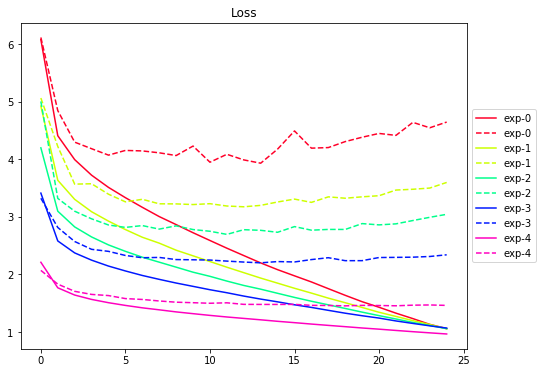

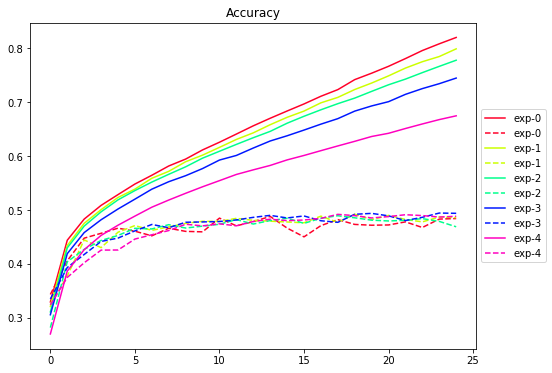

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()